<a href="https://colab.research.google.com/github/tmathema/myrepo/blob/master/SciBERT_bartsummaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains code used to finetune the BART model to summarise UCT publications. 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.0 MB/s 
     |████████████████████████████████| 3.5 MB 25.7 MB/s 
     |████████████████████████████████| 6.8 MB 28.1 MB/s 
     |████████████████████████████████| 1.2 MB 66.9 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 596 kB 65.0 MB/s 
     |████████████████████████████████| 895 kB 75.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=a7ff12a7c04cd60e3eb164f288c486fc0945590727e8c6049179dbaa752f2ecc
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install torch
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import re
import time
import datetime as datetime
import os 
from pandas import DataFrame
import transformers
from transformers import BertTokenizer, BertModel
import nltk
import torch


In [ ]:
#import pickle
#with open('/content/gdrive/MyDrive/bart_summary.pkl', 'rb') as f:
 # data = pickle.load(f)

In [ ]:
data = pd.read_pickle('/content/gdrive/MyDrive/bart_summarydf.pkl')

In [ ]:
X_test = pd.read_pickle('/content/gdrive/MyDrive/X_test.pkl')

In [ ]:
X_test = X_test.reset_index(drop = True)

In [ ]:
X_test.title.iloc[0]

'Learning from the rhetoric of academics using educational technology'

In [ ]:
data.head()

,summary
0,"[' Background: Seminar presentations, by acade..."
1,[' Background: Since 1994 the South African go...
2,[' ATLAS Collaboration) I. The multi-TeV energ...
3,"[' This cross-sectional, observational study i..."
4,[' Objective: To investigate the impact of ant...


In [ ]:
#summaries = []
#for i in range(len(data)):
#  values = ' '.join(str(v) for v in data[i])
 # summaries.append(values)

In [ ]:
#summaries = pd.DataFrame(summaries, columns=['text'])

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

  
    #text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"�", "", text) #remove � character from text
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(r"(\'\] \[)", " ", text)
   
    return text

data['text1'] = data.summary.apply(text_preprocessing)


In [ ]:
summaries = data.text1

In [ ]:
sentences = data.text1.astype('str').tolist()

In [ ]:
len(sentences)

1107

In [ ]:
def bert_text_preparation(text, tokenizer):
    """Preparing the input for BERT
    
    Takes a string argument and performs
    pre-processing like adding special tokens,
    tokenization, tokens to ids, and tokens to
    segment ids. All tokens are mapped to seg-
    ment id = 1.
    
    Args:
        text (str): Text to be converted
        tokenizer (obj): Tokenizer object
            to convert text into BERT-re-
            adable tokens and ids
        
    Returns:
        list: List of BERT-readable tokens
        obj: Torch tensor with token ids
        obj: Torch tensor segment ids
    
    
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors
    
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Get embeddings from an embedding model
    
    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids
    
    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token
    
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings


In [ ]:
from transformers import *
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

In [ ]:
#tokenizer.save_pretrained('/content/gdrive/MyDrive/tokenizer/')
#model.save_pretrained('/content/gdrive/MyDrive/tokenizer/')

tokenizer config file saved in /content/gdrive/MyDrive/tokenizer/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/tokenizer/special_tokens_map.json
Configuration saved in /content/gdrive/MyDrive/tokenizer/config.json
Model weights saved in /content/gdrive/MyDrive/tokenizer/pytorch_model.bin


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('/content/gdrive/MyDrive/tokenizer/')
model = AutoModel.from_pretrained('/content/gdrive/MyDrive/tokenizer/')

In [ ]:
t = []
for i in range(len(sentences)):
  token = bert_text_preparation(sentences[i], tokenizer)
  t.append(token)

In [ ]:
t[0]

(['[CLS]',
  '[',
  "'",
  'background',
  ':',
  'seminar',
  'presentations',
  ',',
  'by',
  'academic',
  '##s',
  'successfully',
  'using',
  'educational',
  'technology',
  'to',
  'support',
  'their',
  'courses',
  ',',
  'form',
  'a',
  'visible',
  'part',
  'of',
  'many',
  'staff',
  'development',
  'programmes',
  '.',
  'we',
  'argue',
  'that',
  'this',
  'epid',
  '##ei',
  '##ct',
  '##ic',
  'form',
  'is',
  'a',
  'vital',
  'component',
  'in',
  'emerging',
  'communities',
  'of',
  'practice',
  'and',
  ',',
  'for',
  'example',
  ',',
  'communicate',
  '##s',
  'the',
  'value',
  'of',
  'working',
  'collaborative',
  '##ly',
  '.',
  'we',
  'observe',
  'that',
  'the',
  'purpose',
  'is',
  'not',
  'primarily',
  'about',
  'presenting',
  'facts',
  'or',
  'an',
  'argument',
  'about',
  'a',
  'state',
  'of',
  'affairs',
  ',',
  'thus',
  'these',
  'speech',
  '##es',
  'are',
  'not',
  'forensic',
  'or',
  'deliber',
  '##ative',
 

In [ ]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

word_embedding_model = models.Transformer('allenai/scibert_scivocab_uncased', max_seq_length=512)

pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), \
                               pooling_mode_max_tokens = False, \
                               pooling_mode_mean_tokens = False,
                               pooling_mode_mean_sqrt_len_tokens = True)

# DENSE MODEL:
# Add two trainable feed-forward networks (DAN)
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=768, activation_function=nn.Tanh())
# Here, we add a on top of the pooling layer a fully connected dense layer with Tanh activation
# A fully-connected feed-forward network to create a Deep Averaging Network (DAN). You can stack multiple Dense models. 



sentence_embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model]) # pooling_mo

In [ ]:
print("Max Sequence Length:", sentence_embedding_model.max_seq_length)

Max Sequence Length: 512


In [ ]:
#Sentences are encoded by calling model.encode()
summary_embeddings = sentence_embedding_model.encode(sentences, batch_size = 128, convert_to_numpy = True, show_progress_bar=True)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
summary_embeddings = pd.DataFrame(summary_embeddings)

In [ ]:
summary_embeddings.shape

(1107, 768)

In [ ]:
bert_metadata = pd.concat([summaries, X_test, summary_embeddings], axis=1)

In [ ]:
titles = bert_metadata.title

In [ ]:
from sklearn.manifold import TSNE
tsne_20 = TSNE(n_components=2, method='exact', verbose = 1, random_state = 32, n_iter = 1000, perplexity = 20)

In [ ]:
from sklearn.manifold import TSNE
tsne_30 = TSNE(n_components=2, method='exact', verbose = 1, random_state = 32, n_iter = 1000, perplexity = 30)

In [ ]:
from sklearn.manifold import TSNE
tsne_50 = TSNE(n_components=2, method='exact', verbose = 1, random_state = 32, n_iter = 1000, perplexity = 50)

In [ ]:
tsne20_obj= tsne_20.fit_transform(summary_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1107
[t-SNE] Computed conditional probabilities for sample 1107 / 1107
[t-SNE] Mean sigma: 3.352249
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.320530
[t-SNE] KL divergence after 1000 iterations: 1.403410


In [ ]:
tsne30_obj= tsne_30.fit_transform(summary_embeddings)

[t-SNE] Computing pairwise distances...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1107
[t-SNE] Computed conditional probabilities for sample 1107 / 1107
[t-SNE] Mean sigma: 3.556549
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.538751
[t-SNE] KL divergence after 1000 iterations: 1.314059


In [ ]:
tsne50_obj= tsne_50.fit_transform(summary_embeddings)

[t-SNE] Computing pairwise distances...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1107
[t-SNE] Computed conditional probabilities for sample 1107 / 1107
[t-SNE] Mean sigma: 3.821797
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.092170
[t-SNE] KL divergence after 1000 iterations: 1.281540


In [ ]:
tsne20_df = pd.DataFrame(tsne20_obj, columns = ('dim1', 'dim2'))
tsne20_df["title"] = titles
#tsne_df['tokens'] = list(sentences_tokenized)
tsne20_df.head(10)

,dim1,dim2,title
0,39.014965,53.808113,Learning from the rhetoric of academics using ...
1,44.636669,48.388054,Race and assessment practice in South Africa: ...
2,-2.489029,-84.486351,Search for magnetic monopoles and stable parti...
3,-1.852567,9.328830,Sleep and BMI in South African urban and rural...
4,-21.824741,-4.066247,Predicting the long-term impact of antiretrovi...
5,26.295542,20.956680,The Pan-University Network for Global Health: ...
6,2.643241,39.193195,A process evaluation exploring the lay counsel...
7,3.178382,41.188057,The secret life of young adolescents living wi...
8,9.464358,-38.360023,Herbivores shape woody plant communities in th...
9,-27.942669,31.024958,"Water, Sanitation, and Hygiene Vulnerability a..."


In [ ]:
tsne30_df = pd.DataFrame(tsne30_obj, columns = ('dim1', 'dim2'))
tsne30_df["title"] = titles
#tsne_df['tokens'] = list(sentences_tokenized)
tsne30_df.head(10)

,dim1,dim2,title
0,-6.335320,60.653625,Learning from the rhetoric of academics using ...
1,-6.592275,56.039467,Race and assessment practice in South Africa: ...
2,-19.521587,-75.530769,Search for magnetic monopoles and stable parti...
3,14.045636,15.846197,Sleep and BMI in South African urban and rural...
4,-12.375743,5.523417,Predicting the long-term impact of antiretrovi...
5,-25.113131,23.126701,The Pan-University Network for Global Health: ...
6,12.706347,36.281986,A process evaluation exploring the lay counsel...
7,15.071498,35.097939,The secret life of young adolescents living wi...
8,5.567737,-39.269325,Herbivores shape woody plant communities in th...
9,-20.842937,9.678863,"Water, Sanitation, and Hygiene Vulnerability a..."


In [ ]:
tsne50_df = pd.DataFrame(tsne50_obj, columns = ('dim1', 'dim2'))
tsne50_df["title"] = titles
#tsne_df['tokens'] = list(sentences_tokenized)
tsne50_df.head(10)

,dim1,dim2,title
0,-44.976524,-1.301254,Learning from the rhetoric of academics using ...
1,-40.930557,-4.408548,Race and assessment practice in South Africa: ...
2,-0.902444,53.592339,Search for magnetic monopoles and stable parti...
3,-5.041106,2.484263,Sleep and BMI in South African urban and rural...
4,1.943518,-21.451687,Predicting the long-term impact of antiretrovi...
5,-28.916800,4.297657,The Pan-University Network for Global Health: ...
6,-19.578682,-2.092535,A process evaluation exploring the lay counsel...
7,-16.628548,-2.483488,The secret life of young adolescents living wi...
8,11.864149,-28.138330,Herbivores shape woody plant communities in th...
9,9.708228,-21.242809,"Water, Sanitation, and Hygiene Vulnerability a..."


# Spectral clustering

In [ ]:
# Modelling Helpers, see above the description
from sklearn.cluster import SpectralClustering
import pandas as pd
import numpy as np
import pickle
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score 

In [ ]:
from scipy.spatial.distance import pdist, squareform
def getAffinityMatrix(coordinates, k = 10):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

In [ ]:
import scipy
from scipy.sparse import csgraph
# from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.xlabel('number of eigen values')
        plt.ylabel('eigen values')
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Optimal number of clusters [138 145 148 206 214]


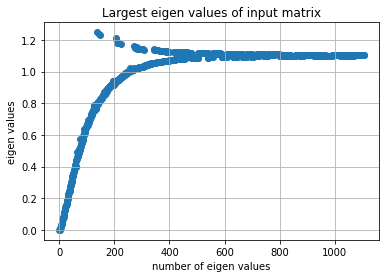

In [ ]:
affinity_matrix = getAffinityMatrix(tsne20_df.iloc[:,:2], k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')

Optimal number of clusters [ 86 160 166 230 242]


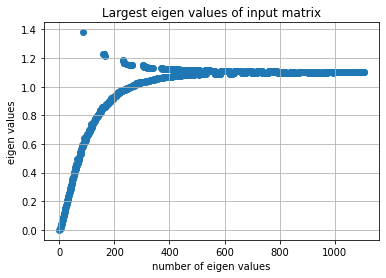

In [ ]:
affinity_matrix = getAffinityMatrix(tsne30_df.iloc[:,:2], k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')

Optimal number of clusters [166 170 219 227 237]


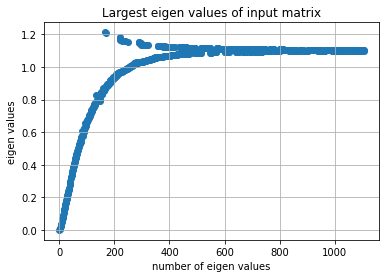

In [ ]:
affinity_matrix = getAffinityMatrix(tsne50_df.iloc[:,:2], k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')

In [ ]:
# the default k-means label assignment didn't work well
clustering_20 = SpectralClustering(n_clusters=138, random_state = 2, n_neighbors = 10,
                                affinity ='rbf', assign_labels="discretize").fit(tsne20_df.iloc[:,:2])

In [ ]:
# the default k-means label assignment didn't work well
clustering_30 = SpectralClustering(n_clusters= 86, random_state = 2, n_neighbors = 10,
                                affinity ='rbf', assign_labels="discretize").fit(tsne30_df.iloc[:,:2])

In [ ]:
# the default k-means label assignment didn't work well
clustering_50 = SpectralClustering(n_clusters=166, random_state = 2, n_neighbors = 10,
                                affinity ='rbf', assign_labels="discretize").fit(tsne50_df.iloc[:,:2])

In [ ]:
y_pred_tsne20 = pd.DataFrame(clustering_20.labels_)
y_pred_tsne30 = pd.DataFrame(clustering_30.labels_)
y_pred_tsne50 = pd.DataFrame(clustering_50.labels_)

In [ ]:
import sklearn.metrics as metrics
metrics.silhouette_score(tsne20_df.iloc[:,:2], y_pred_tsne20, metric='euclidean')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.17914309

In [ ]:
metrics.silhouette_score(tsne30_df.iloc[:,:2], y_pred_tsne30, metric='euclidean')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.092696704

In [ ]:
metrics.silhouette_score(tsne50_df.iloc[:,:2], y_pred_tsne50, metric='euclidean')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.30471256

In [ ]:
tsne20_df['labels'] = y_pred_tsne20
tsne30_df['labels'] = y_pred_tsne30
tsne50_df['labels'] = y_pred_tsne50

In [ ]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

In [ ]:
from bokeh.models import ColumnDataSource, ColorBar
from bokeh.palettes import d3
from bokeh.transform import linear_cmap

In [ ]:
from bokeh.transform import linear_cmap
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
from bokeh.palettes import Viridis256, Turbo256, Inferno256, Greys256
from bokeh.models import CategoricalColorMapper
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.transform import transform
from bokeh.plotting import figure,show

output_notebook()
plot_tsne = bp.figure(plot_width = 700, plot_height = 500, 
                       title = "Clustering of UCT publication(t-SNE of 20 perplexity dimensionsinality reduction)",
                       tools = "pan, wheel_zoom, box_zoom, reset, hover, save",
                       x_axis_type = None, y_axis_type = None, min_border = 1)

#palette = d3["Category20"][len(tsne1020_df["labels"].unique())]
#mapper = linear_cmap(field_name='labels', palette=palette ,low=min(tsne1020_df["labels"]) ,high=max(tsne1020_df["labels"]))
mapper = LinearColorMapper(palette='Turbo256', low=tsne20_df["labels"].min() ,high=tsne20_df["labels"].max())

#color_map = CategoricalColorMapper(factors = umap1020_df["labels"].unique(), palette = palette)

plot_tsne.scatter(x = "dim1", y = "dim2", 
                 color= transform('labels', mapper), 
                 source = tsne20_df,
                 alpha = 0.7)
#color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0),title="cluster labels")
color_bar = ColorBar(color_mapper = mapper,
                     label_standoff = 14,
                     location = (0,0),
                     title = 'Plot')
plot_tsne.add_layout(color_bar, 'right')
hover = plot_tsne.select(dict(type = HoverTool))
hover.tooltips = {"paper": "@title"}

show(plot_tsne)

In [ ]:
from bokeh.transform import linear_cmap
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
from bokeh.palettes import Viridis256, Turbo256, Inferno256, Greys256
from bokeh.models import CategoricalColorMapper
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.transform import transform
from bokeh.plotting import figure,show

output_notebook()
plot_tsne = bp.figure(plot_width = 700, plot_height = 500, 
                       title = "Clustering of UCT publication(t-SNE of 30 perplexity dimensionsinality reduction)",
                       tools = "pan, wheel_zoom, box_zoom, reset, hover, save",
                       x_axis_type = None, y_axis_type = None, min_border = 1)

#palette = d3["Category20"][len(tsne1020_df["labels"].unique())]
#mapper = linear_cmap(field_name='labels', palette=palette ,low=min(tsne1020_df["labels"]) ,high=max(tsne1020_df["labels"]))
mapper = LinearColorMapper(palette='Turbo256', low=tsne30_df["labels"].min() ,high=tsne30_df["labels"].max())

#color_map = CategoricalColorMapper(factors = umap1020_df["labels"].unique(), palette = palette)

plot_tsne.scatter(x = "dim1", y = "dim2", 
                 color= transform('labels', mapper), 
                 source = tsne30_df,
                 alpha = 0.7)
#color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0),title="cluster labels")
color_bar = ColorBar(color_mapper = mapper,
                     label_standoff = 14,
                     location = (0,0),
                     title = 'Plot')
plot_tsne.add_layout(color_bar, 'right')
hover = plot_tsne.select(dict(type = HoverTool))
hover.tooltips = {"paper": "@title"}

show(plot_tsne)

In [ ]:
from bokeh.transform import linear_cmap
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
from bokeh.palettes import Viridis256, Turbo256, Inferno256, Greys256
from bokeh.models import CategoricalColorMapper
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.transform import transform
from bokeh.plotting import figure,show

output_notebook()
plot_tsne = bp.figure(plot_width = 700, plot_height = 500, 
                       title = "Clustering of UCT publication(t-SNE of 50 perplexity dimensionsinality reduction)",
                       tools = "pan, wheel_zoom, box_zoom, reset, hover, save",
                       x_axis_type = None, y_axis_type = None, min_border = 1)

#palette = d3["Category20"][len(tsne1020_df["labels"].unique())]
#mapper = linear_cmap(field_name='labels', palette=palette ,low=min(tsne1020_df["labels"]) ,high=max(tsne1020_df["labels"]))
mapper = LinearColorMapper(palette='Turbo256', low=tsne50_df["labels"].min() ,high=tsne50_df["labels"].max())

#color_map = CategoricalColorMapper(factors = umap1020_df["labels"].unique(), palette = palette)

plot_tsne.scatter(x = "dim1", y = "dim2", 
                 color= transform('labels', mapper), 
                 source = tsne50_df,
                 alpha = 0.7)
#color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0),title="cluster labels")
color_bar = ColorBar(color_mapper = mapper,
                     label_standoff = 14,
                     location = (0,0),
                     title = 'Plot')
plot_tsne.add_layout(color_bar, 'right')
hover = plot_tsne.select(dict(type = HoverTool))
hover.tooltips = {"paper": "@title"}

show(plot_tsne)

## UMAP Spectral clustering

In [ ]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 3.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311899 sha256=b9732d3d4f36c5f3d6ca4ddf4f73231a8f3c608baf0f69ca8da99e6490f7e0d8
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 39.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=15ce77600bfe7059b6e04d10a09259bf6c04397f8716de4c7e4253b0ee6c7960
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=36d039562273bb834c192d932ac7a04143da95a90a218b4537845252ffac540c
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
import random
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
import umap.umap_ as umap
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [ ]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [ ]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [ ]:
def random_search(embeddings, space, num_evals):
    """
    Randomly search parameter space of clustering pipeline

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               and 'min_cluster_size' and values with
               corresponding lists or ranges of parameters to search
        num_evals: int, number of random parameter combinations to try

    Returns:
        df_result: pandas dataframe containing info on each evaluation
                   performed, including run_id, parameters used, label
                   count, and cost
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        min_samples = random.choice(space['min_samples'])
        random_state = space['random_state']
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors=n_neighbors, 
                                     n_components=n_components, 
                                     min_cluster_size=min_cluster_size, 
                                     min_samples = min_samples,
                                     random_state=random_state)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, min_samples, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size','min_samples', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [ ]:
def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize

    Arguments:
        params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'random_state' and
               their values to use for evaluation
        embeddings: embeddings to use
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters

    Returns:
        loss: cost function result incorporating penalties for falling
              outside desired range for number of clusters
        label_count: int, number of unique cluster labels, including noise
        status: string, hypoeropt status

        """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 min_samples = params['min_samples'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.60 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [ ]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

        """
    
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [ ]:
space = {
        "n_neighbors": range(5,20),
        "n_components": range(2,50),
        "min_cluster_size": range(2,10),
        "min_samples": range(5,10),
        "random_state": 42
    }

random_use = random_search(summary_embeddings, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
random_use

,run_id,n_neighbors,n_components,min_cluster_size,min_samples,label_count,cost
0,0,10,41,3,6,2,0.000000
66,66,19,42,2,5,2,0.000000
62,62,14,16,7,8,2,0.000000
61,61,15,38,9,9,2,0.000000
60,60,6,21,5,5,3,0.000000
58,58,19,49,9,7,2,0.000000
57,57,16,9,3,5,2,0.000000
56,56,18,26,3,7,2,0.000000
67,67,15,46,8,7,2,0.000000
55,55,7,36,9,9,3,0.000000


In [ ]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(2,15)),
    "n_components": hp.choice('n_components', range(2,50)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,10)),
    "min_samples": hp.choice('min_samples', range(2,10)),
    "random_state": 42
}
label_lower = 10
label_upper = 100
max_evals = 100

In [ ]:
best_params_use, best_clusters_use, trials_use = bayesian_search(summary_embeddings, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)



 80%|████████  | 80/100 [07:57<02:02,  6.13s/it, best loss: 0.11291779584462511]

/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"



100%|██████████| 100/100 [09:55<00:00,  5.96s/it, best loss: 0.11291779584462511]
best:
{'min_cluster_size': 8, 'min_samples': 2, 'n_components': 49, 'n_neighbors': 3, 'random_state': 42}
label count: 58


In [ ]:
#'min_cluster_size': 8, 'min_samples': 2, 'n_components': 49, 'n_neighbors': 3, 'random_state': 42}
#randim search 33	45	12	5	23
#15	7	2	5	
#'min_cluster_size': 8, 'min_samples': 4, 'n_components': 39, 'n_neighbors': 3, 'random_state': 42}
n_neighbors = 3
n_components = 26
umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=42)
                            .fit_transform(summary_embeddings))

In [ ]:
import hdbscan
#7,9 optimum
hbscan_min_clustersize = 8
hbscan_min_sample = 2

cluster_umap = hdbscan.HDBSCAN(min_cluster_size = hbscan_min_clustersize, 
                               min_samples = hbscan_min_sample,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom',
                               cluster_selection_epsilon = 0.1,).fit(umap_embeddings)


In [ ]:
labels_umap = pd.DataFrame(cluster_umap.labels_)

In [ ]:
labels_umap.value_counts()

In [ ]:
import sklearn.metrics as metrics
metrics.silhouette_score(umap_embeddings, labels_umap, metric='euclidean')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.36006537

In [ ]:
n_neighbors = 3
n_components = 2
umap_embeddings_2 = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=42)
                            .fit_transform(summary_embeddings))

In [ ]:
umap_embeddings_2 = pd.DataFrame(umap_embeddings_2, columns = ('dim1', 'dim2'))
umap_embeddings_2["title"] = titles
#tsne_df['tokens'] = list(sentences_tokenized)
umap_embeddings_2['labels'] = labels_umap
umap_embeddings_2.head(1)

,dim1,dim2,title,labels
0,8.98023,-0.077584,Learning from the rhetoric of academics using educational technology,53


In [ ]:
from bokeh.transform import linear_cmap
#from bokeh.palettes import d3
from bokeh.palettes import Viridis256, Turbo256, Inferno256, Greys256
from bokeh.models import CategoricalColorMapper
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.transform import transform
from bokeh.plotting import figure,show

output_notebook()
plot_tsne = bp.figure(plot_width = 700, plot_height = 500, 
                       title = "clustering of UCT publication(umap embeddings) BART",
                       tools = "pan, wheel_zoom, box_zoom, reset, hover, save",
                       x_axis_type = None, y_axis_type = None, min_border = 1)

#palette = d3["Category20"][len(tsne230_df["labels"].unique())]
#mapper = linear_cmap(field_name='labels', palette=palette ,low=min(tsne220_df["labels"]) ,high=max(tsne220_df["labels"]))

mapper = LinearColorMapper(palette='Turbo256', low=umap_embeddings_2["labels"].min() ,high=umap_embeddings_2["labels"].max())
#color_map = CategoricalColorMapper(factors = umap1020_df["labels"].unique(), palette = palette)

plot_tsne.scatter(x = "dim1", y = "dim2", 
                 color= transform('labels', mapper), 
                 source = umap_embeddings_2,
                 alpha = 0.7)
#color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0),title="cluster labels")
color_bar = ColorBar(color_mapper = mapper,
                     label_standoff = 14,
                     location = (0,0),
                     title = 'Plot')

plot_tsne.add_layout(color_bar, 'right')
hover = plot_tsne.select(dict(type = HoverTool))
hover.tooltips = {"paper": "@title"}

show(plot_tsne)

In [ ]:
import collections
from pathlib import Path
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 10030000

In [ ]:
def get_group(df, category_col, category):
    """
    Returns documents of a single category
    
    Arguments:
        df: pandas dataframe of documents
        category_col: str, column name corresponding to categories or clusters
        category: int, cluster number to return
    Returns:
        single_category: pandas dataframe with documents from a single category
    """
    
    single_category = df[df[category_col]==category].reset_index(drop=True)

    return single_category 

In [ ]:
def most_common(lst, n_words):
    """
    Get most common words in a list of words
    
    Arguments:
        lst: list, each element is a word
        n_words: number of top common words to return
    
    Returns:
        counter.most_common(n_words): counter object of n most common words
    """
    counter=collections.Counter(lst)
    return counter.most_common(n_words)

In [ ]:
def apply_and_summarize_labels(df, category_col):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """
    
    numerical_labels = df[category_col].unique()
    
    # create dictionary of the numerical category to the generated label
    label_dict = {}
    for label in numerical_labels:
        current_category = list(get_group(df, category_col, label)['text'])
        label_dict[label] = extract_labels(current_category)
        
    # create summary dataframe of numerical labels and counts
    summary_df = (df.groupby(category_col)['text'].count()
                    .reset_index()
                    .rename(columns={'text':'count'})
                    .sort_values('count', ascending=False))
    
    # apply generated labels
    summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]], axis = 1)
    
    return summary_df

In [ ]:
def extract_labels(category_docs, print_word_counts=True):
    """
    Extract labels from documents in the same cluster by concatenating
    most common verbs, objects, and nouns

    Argument:
        category_docs: list of documents, all from the same category or
                       clustering
        print_word_counts: bool, True will print word counts of each type in this category

    Returns:
        label: str, group label derived from concatentating most common
               verb, object, and two most common nouns

    """

    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to 
    # running lists for whole cluster
    for i in range(len(category_docs)):
        doc = nlp(category_docs[i])
        for token in doc:
            if token.is_stop==False:
                if token.dep_ == 'ROOT':
                    verbs.append(token.text.lower())

                elif token.dep_=='dobj':
                    dobjs.append(token.lemma_.lower())

                elif token.pos_=='NOUN':
                    nouns.append(token.lemma_.lower())
                    
                elif token.pos_=='ADJ':
                    adjs.append(token.lemma_.lower())

    # for printing out for inspection purposes
    if print_word_counts:
        for word_lst in [verbs]:
            counter=collections.Counter(word_lst)
            counter_verbs = counter

        for word_lst in [dobjs]:
            counter=collections.Counter(word_lst)
            counter_dobjs = counter

        for word_lst in [nouns]:
            counter=collections.Counter(word_lst)
            counter_nouns = counter
        
        for word_lst in [adjs]:
            counter=collections.Counter(word_lst)
            counter_adjs = counter
    
    # take most common words of each form
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]
    
    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]
    
    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]
    
    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]
    
    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)
    
    if '' in label_words:
        label_words.remove('')
    
    label = '_'.join(label_words)
    
    return label, counter_verbs, counter_dobjs, counter_nouns, counter_adjs

In [ ]:
bert_metadata['labels'] = labels_umap

In [ ]:
emb_df = pd.concat([summary_embeddings, labels_umap], axis = 1)

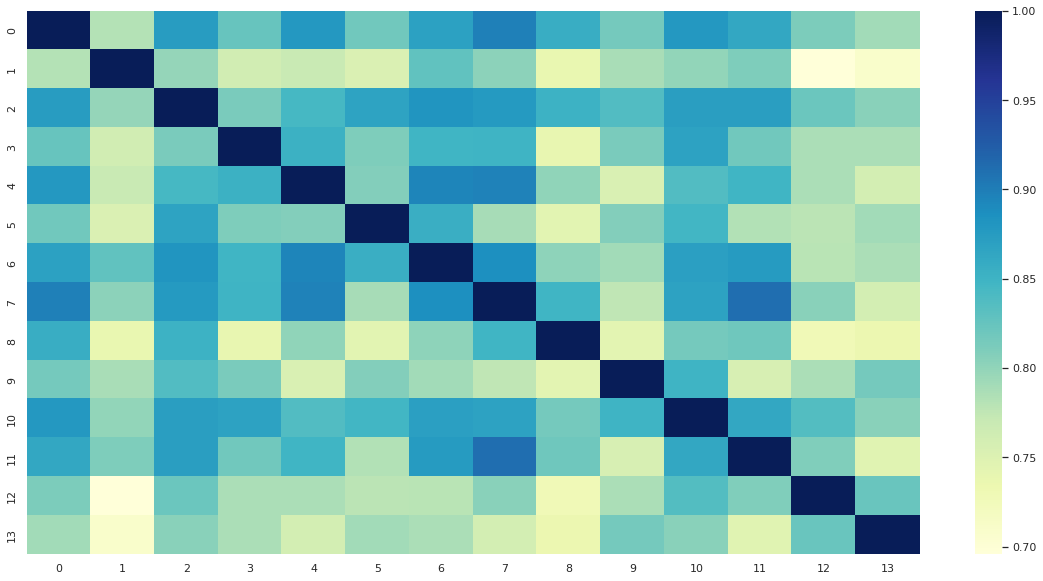

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; sns.set_theme()
X = emb_df[emb_df.iloc[: , -1] == 0]
cosinesimilarity1 = cosine_similarity(X.iloc[: , :-1].dropna())
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(cosinesimilarity1, ax=ax, cmap = 'YlGnBu')

In [ ]:
Y =bert_metadata[bert_metadata['labels'] == 0]

In [ ]:
Y.title

2                                                                                Search for magnetic monopoles and stable particles with high electric charges in 8 TeV pp collisions with the ATLAS detector
79      Measurement of the cross-section of high transverse momentum vector bosons reconstructed as single jets and studies of jet substructure in pp collisions at $sqrt{s}$ = 7 TeV with the ATLAS detector
140                                                                                                                                 Event-by-event mean pT fluctuations in pp and Pb–Pb collisions at the LHC
294                                                                                                                                        Search for Higgs and Z Boson Decays to ϕ γ with the ATLAS Detector
357                                                                    Search for new phenomena in different-flavour high-mass dilepton final states in pp collisions at root s=

In [ ]:
!pip install networkx
g = bert_metadata['Author_'].str.split(';', expand=True)

In [ ]:
labels_umap = labels_umap.rename(columns={0: 'labels'})

In [ ]:
data_graph = pd.concat([g, labels_umap], axis = 1)

In [ ]:
data_graph.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,labels
0,"Deacon, Andrew\n","\nWynsculley, Cathrine",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,53


In [ ]:
graph_data = data_graph.set_index('labels').stack().reset_index()

In [ ]:
graph_data.head(1)

,labels,level_1,0
0,35,0,"Deacon, Andrew\n"


In [ ]:
graph_data = graph_data.rename(columns={0: 'authors'})

In [ ]:
import networkx as nx
G = nx.Graph()

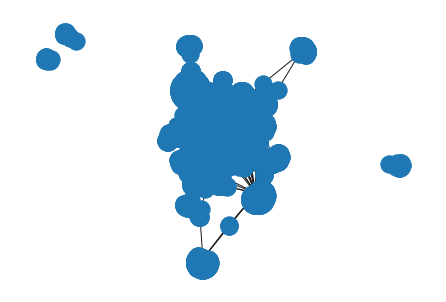

In [ ]:
g = nx.from_pandas_edgelist(graph_data, source='labels', target='authors') 
nx.draw(g)

In [ ]:
authors = list(graph_data.authors.unique())
labels = list(graph_data.labels.unique())

In [ ]:
dict(zip(authors, authors))

In [ ]:
g.degree('Chimusa, Emile R\n')

2

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


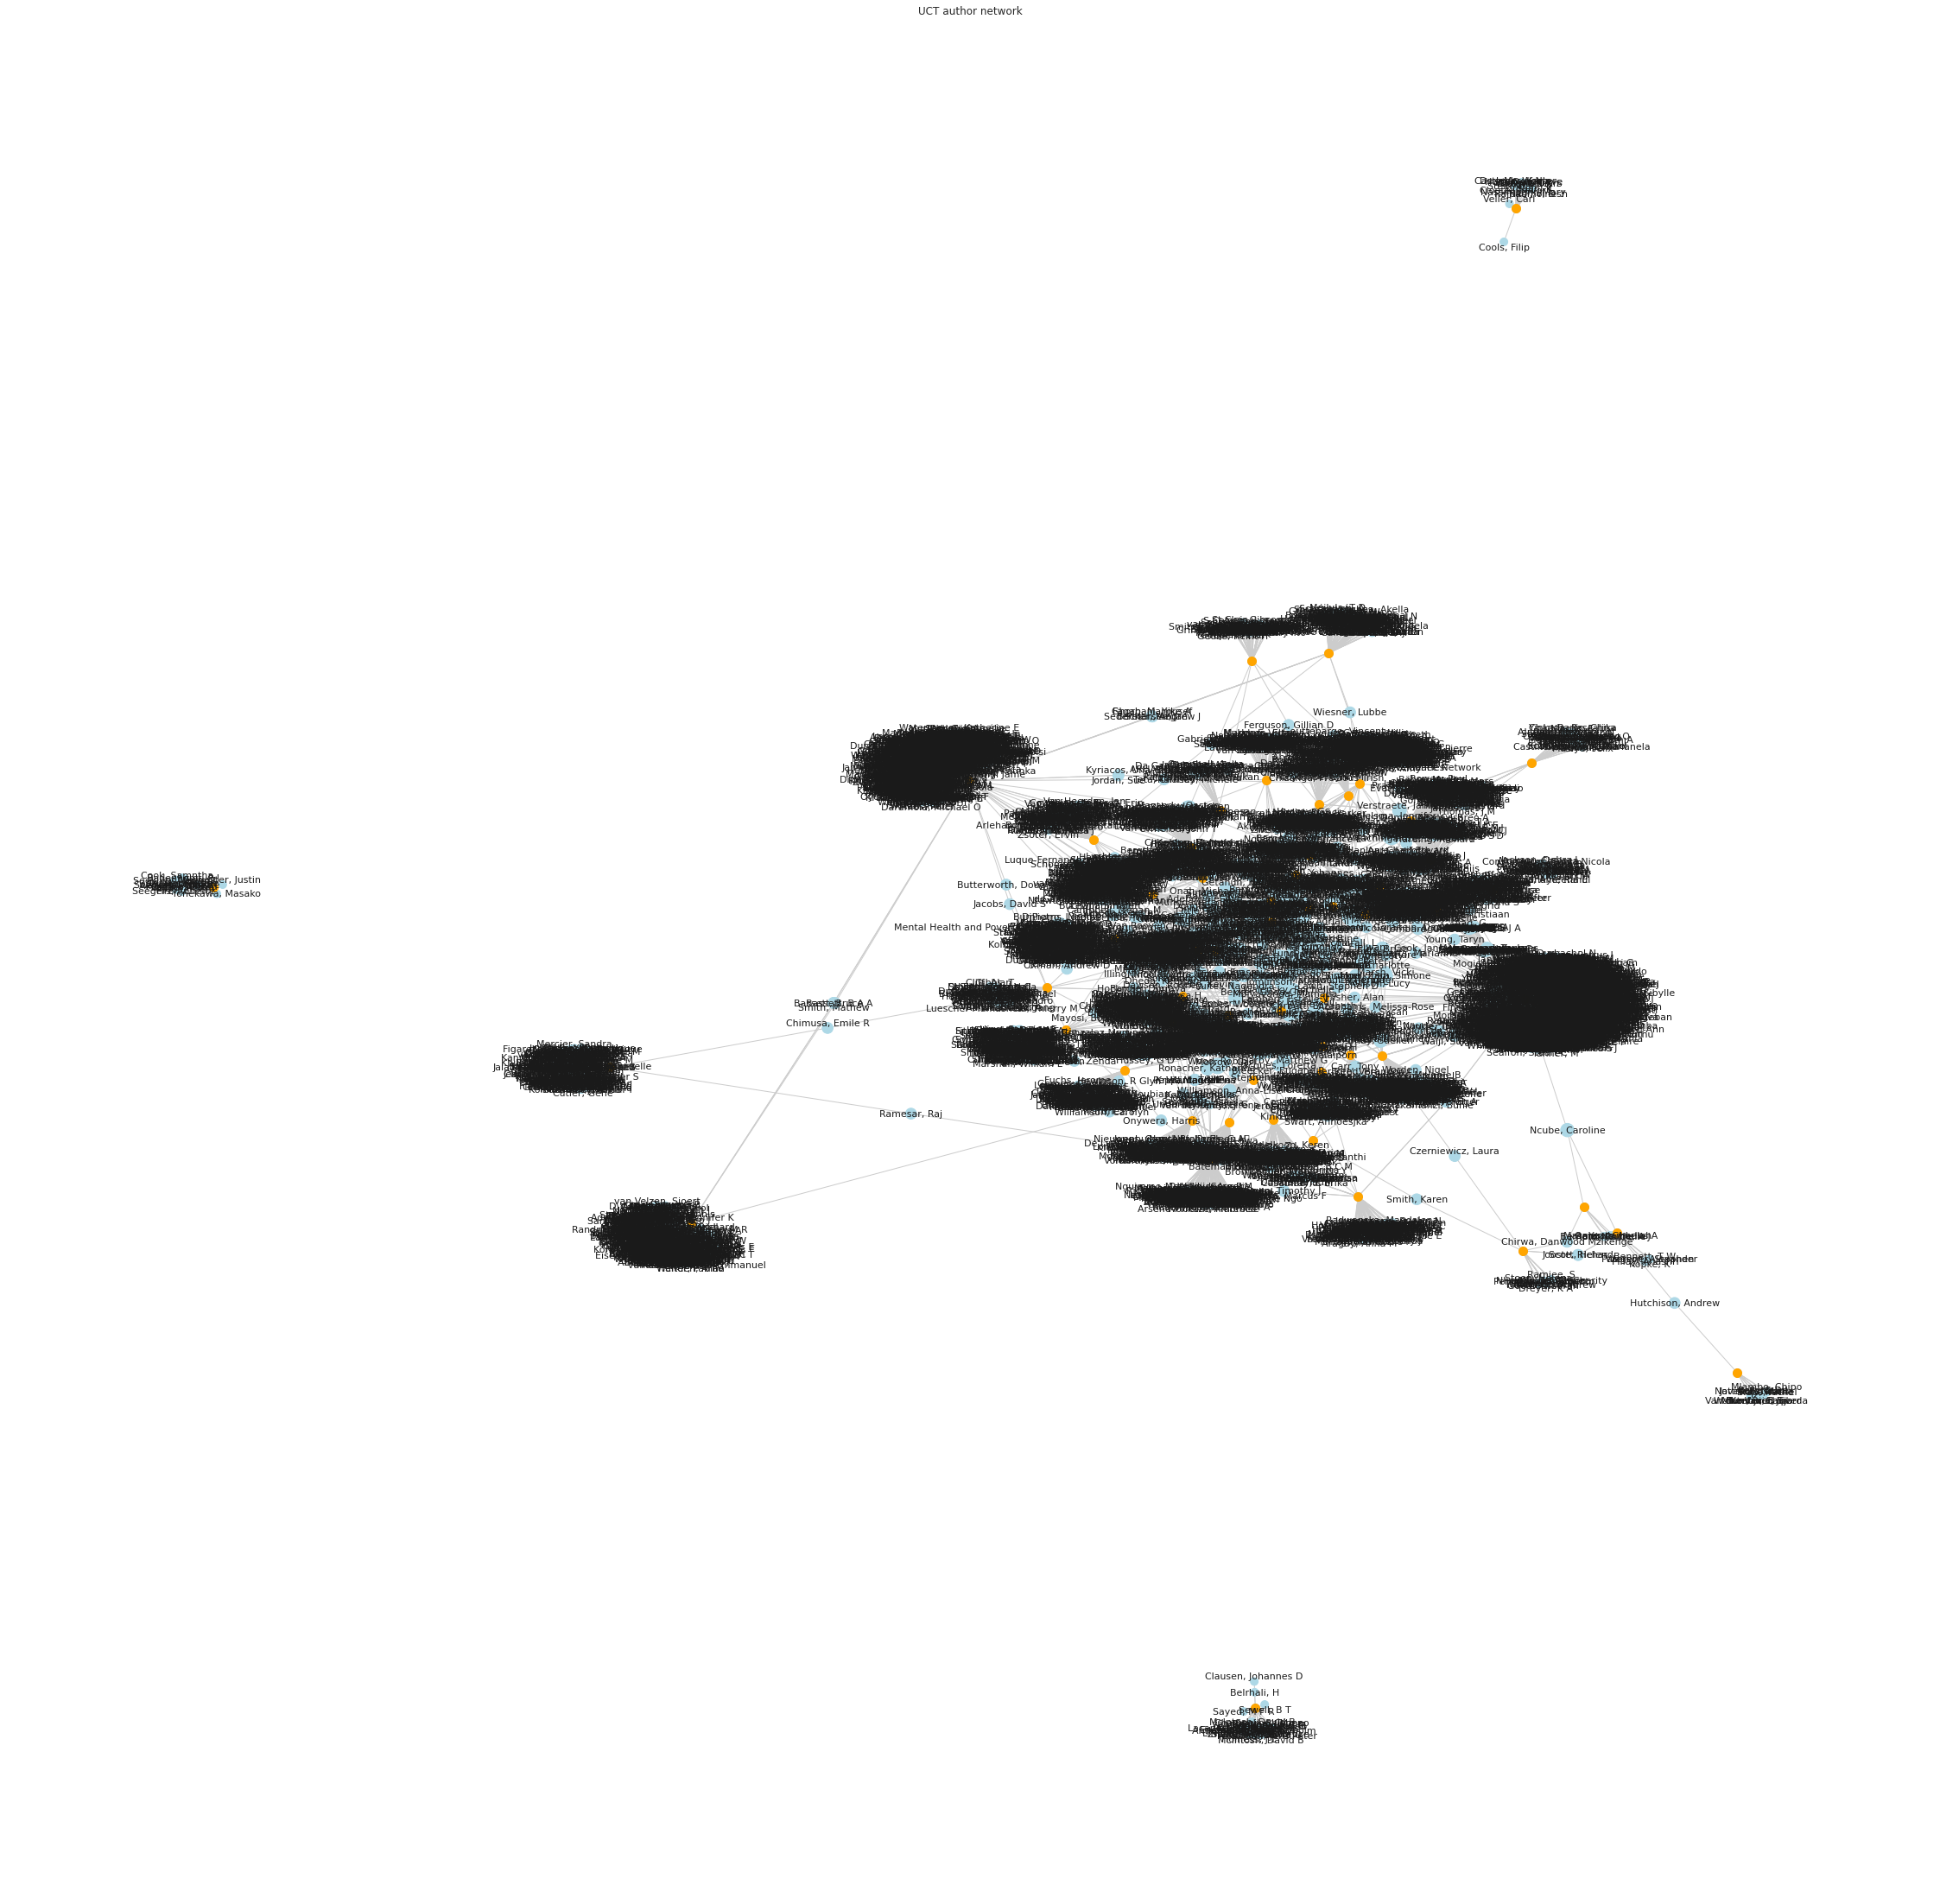

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))

# 1. Create the graph
g = nx.from_pandas_edgelist(graph_data, source='authors', target='labels') 

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=50)

# 3. Draw the parts we want
# Edges thin and grey
# People small and grey
# Clubs sized according to their number of connections
# Clubs blue
# Labels for clubs ONLY
# People who are highly connected are a highlighted color

# Go through every club name, ask the graph how many
# connections it has. Multiply that by 80 to get the circle size
club_size = [g.degree(author) * 80 for author in authors]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=authors, 
                       node_size=club_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw EVERYONE
nx.draw_networkx_nodes(g, layout, nodelist=labels, node_color='#cccccc', node_size=100)

# Draw POPULAR PEOPLE
popular_people = [person for person in labels if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', label=labels, node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(authors, authors))
nx.draw_networkx_labels(g, layout, labels=node_labels, font_size=11)

# 4. Turn off the axis because I know you don't want it
plt.axis('off')

plt.title("UCT author network")

# 5. Tell matplotlib to show it
plt.show()

In [ ]:
example_category = list(get_group(Y, 'labels', 0)['Author_'])
k = extract_labels(example_category, True)

In [ ]:
example_category

['Aad, G\n; \nAbbott, B\n; \nAbdallah, J\n; \nAbdinov, O\n; \nAben, R\n; \nAbolins, M\n; \nAbouZeid, O\u2009S\n; \nAbramowicz, H\n; \nAbreu, H\n; \nAbreu, R\n; \nAbulaiti, Y\n; \nAcharya, B\u2009S\n; \nAdamczyk, L\n; \nAdams, D\u2009L\n; \nAdelman, J\n; \nAdomeit, S\n; \nAdye, T\n; \nAffolder, A\u2009A\n; \nAgatonovic-Jovin, T\n; \nAgricola, J\n; \nAguilar-Saavedra, J\u2009A\n; \nAhlen, S\u2009P\n; \nAhmadov, F\n; \nAielli, G\n; \nAkerstedt, H\n; \nÅkesson, T\u2009P\u2009A\n; \nAkimov, A\u2009V\n; \nAlberghi, G\u2009L\n; \nAlbert, J\n; \nAlbrand, S\n; \nAlconada Verzini, M\u2009J\n; \nAleksa, M',
 'Aad, G\n; \nAbajyan, T\n; \nAbbott, B\n; \nAbdallah, J\n; \nKhalek, S Abdel\n; \nAbdinov, O\n; \nAben, R\n; \nAbi, B\n; \nAbolins, M\n; \nAbouZeid, O S\n; \nAbramowicz, H\n; \nAbreu, H\n; \nAbulaiti, Y\n; \nAcharya, B S\n; \nAdamczyk, L\n; \nAdams, D L\n; \nAddy, T N\n; \nAdelman, J\n; \nAdomeit, S\n; \nAdye, T\n; \nAgatonovic-Jovin, T\n; \nAguilar-Saavedra, J A\n; \nAgustoni, M\n; \nAhlen, 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(Y.Author_)
#vector = vectorizer.transform(Y.Author_)
vectorizer.vocabulary_

{'aaboud': 0,
 'aad': 1,
 'abajyan': 2,
 'abbott': 3,
 'abdallah': 4,
 'abdel': 5,
 'abdinov': 6,
 'abelev': 7,
 'abeloos': 8,
 'aben': 9,
 'abi': 10,
 'abidi': 11,
 'abolins': 12,
 'abouzeid': 13,
 'abraham': 14,
 'abramowicz': 15,
 'abreu': 16,
 'abulaiti': 17,
 'acharya': 18,
 'adachi': 19,
 'adam': 20,
 'adamczyk': 21,
 'adamová': 22,
 'adams': 23,
 'adare': 24,
 'addy': 25,
 'adelman': 26,
 'adomeit': 27,
 'adye': 28,
 'affolder': 29,
 'agatonovic': 30,
 'aggarwal': 31,
 'agheorghiesei': 32,
 'aglieri': 33,
 'agnello': 34,
 'agocs': 35,
 'agostinelli': 36,
 'agrawal': 37,
 'agricola': 38,
 'aguilar': 39,
 'agustoni': 40,
 'ahammed': 41,
 'ahlen': 42,
 'ahmad': 43,
 'ahmadov': 44,
 'ahmed': 45,
 'ahn': 46,
 'aielli': 47,
 'aimo': 48,
 'aiola': 49,
 'ajaz': 50,
 'akatsuka': 51,
 'akerstedt': 52,
 'akimoto': 53,
 'akimov': 54,
 'akindinov': 55,
 'alam': 56,
 'alberghi': 57,
 'albert': 58,
 'albrand': 59,
 'albuquerque': 60,
 'alconada': 61,
 'aleksa': 62,
 'aleksandrov': 63,
 'alessa

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


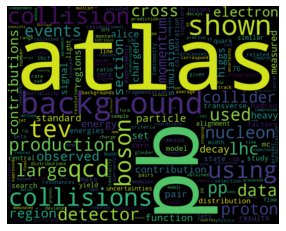

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#bag = pd.DataFrame.from_dict(k[4], orient='index').reset_index()
#d = {}
#for a, x in bag.values:
#  d[a] = x

vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(Y.text1)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

wordcloud = WordCloud(width=1000, height=800)
wordcloud.generate_from_frequencies(df.T.sum(axis=1))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
example_category = list(get_group(bert_metadata, 'labels', 5)['text1'])
k = extract_labels(example_category, True)

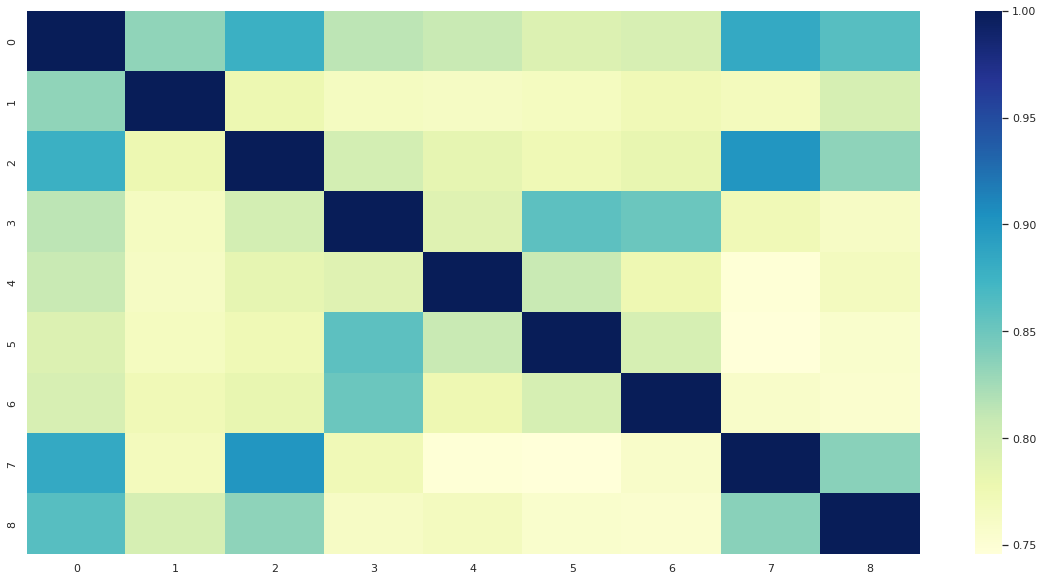

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; sns.set_theme()
X = emb_df[emb_df.iloc[: , -1] == 5]
cosinesimilarity1 = cosine_similarity(X.iloc[: , :-1].dropna())
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(cosinesimilarity1, ax=ax, cmap = 'YlGnBu')

In [ ]:
Y =bert_metadata[bert_metadata['labels'] == 5]

In [ ]:
Y.title

182                                                                 Avoiding frustrations of unprepared students with online quizzes
316                                                                                         Case Study Focus: Papers and Proceedings
424     Designing and implementing an information service model for geography teachers in a developing country: the case for Lesotho
503                                     PMA: Protein Microarray Analyser, a user-friendly tool for data processing and normalization
574                                                             Spatial information systems in managing public transport information
782                                            GenGraph: a python module for the simple generation and manipulation of genome graphs
909                                         Computational selection and prioritization of candidate genes for Fetal Alcohol Syndrome
991                                          Educators' motivation on

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


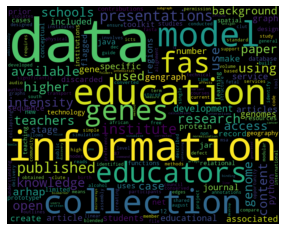

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#bag = pd.DataFrame.from_dict(k[3], orient='index').reset_index()
#d = {}
#for a, x in bag.values:
 # d[a] = x
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(Y.text1)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

wordcloud = WordCloud(width=1000, height=800)
wordcloud.generate_from_frequencies(df.T.sum(axis=1))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
L = bert_metadata[bert_metadata['labels'] == 15]

In [ ]:
L.title

120                                                                   Democratic Civil-Military Relations: A Framework for Analysis
230                                          Opportunities and obstacles to cooperation between the BRICS: A view from South Africa
242                    Competing coalitions: The politics of renewable energy and fossil fuels in Mexico, South Africa and Thailand
331             Multiple targets, mixing strategies: Complicating feminist analysis of contemporary South African women's movements
355                    Writing and teaching the history of unfree labour in Africa and the Indian Ocean in the twenty-first century
486                                               Just admissions: South African universities and the question of racial preference
498    Gender inequitable masculinity and sexual entitlement in rape perpetration South Africa: findings of a cross-sectional study
647                                          Suspension and dissolution of m

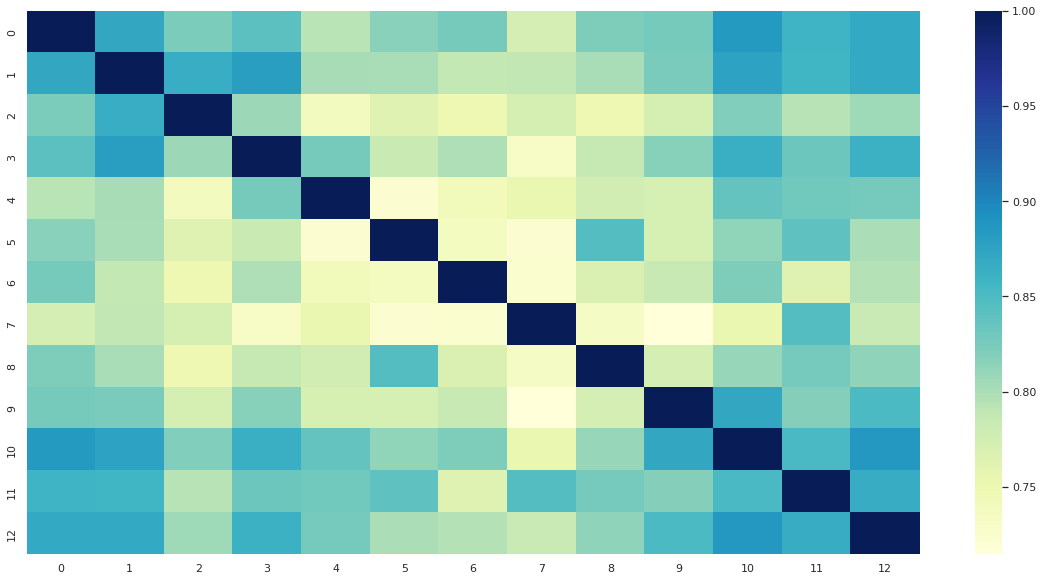

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; sns.set_theme()
X = emb_df[emb_df.iloc[: , -1] == 15]
cosinesimilarity1 = cosine_similarity(X.iloc[: , :-1].dropna())
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(cosinesimilarity1, ax=ax, cmap = 'YlGnBu')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


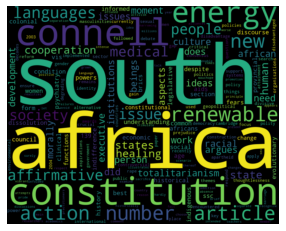

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#bag = pd.DataFrame.from_dict(k[3], orient='index').reset_index()
#d = {}
#for a, x in bag.values:
 # d[a] = x
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(L.text1)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

wordcloud = WordCloud(width=1000, height=800)
wordcloud.generate_from_frequencies(df.T.sum(axis=1))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
sentences = bert_metadata.text1.to_list()

In [ ]:
sent = []

for i in range(len(sentences)):
  s = " "
  
 # joins elements of list1 by '-'
 # and stores in sting s
  s = s.join(sentences[i])
  sent.append(s)

In [ ]:
sent = pd.DataFrame(sent, columns=['text'])
sent['labels'] = labels_umap

In [ ]:
sent.head(5)

In [ ]:
numerical_labels = sent['labels'].unique()
    
    # create dictionary of the numerical category to the generated label
label_dict = {}
for label in numerical_labels:
  current_category = list(get_group(sent, 'labels', label)['text'])
  label_dict = extract_labels(current_category, True)

In [ ]:
cluster_summary = apply_and_summarize_labels(bert_metadata, 'labels')
cluster_summary.head(20)